In [1]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from joblib import Parallel, delayed
from math import log2, ceil
from kdg import kdf
from kdg.synKDF import update_kdf
from kdg.utils import generate_gaussian_parity
import copy
import pickle

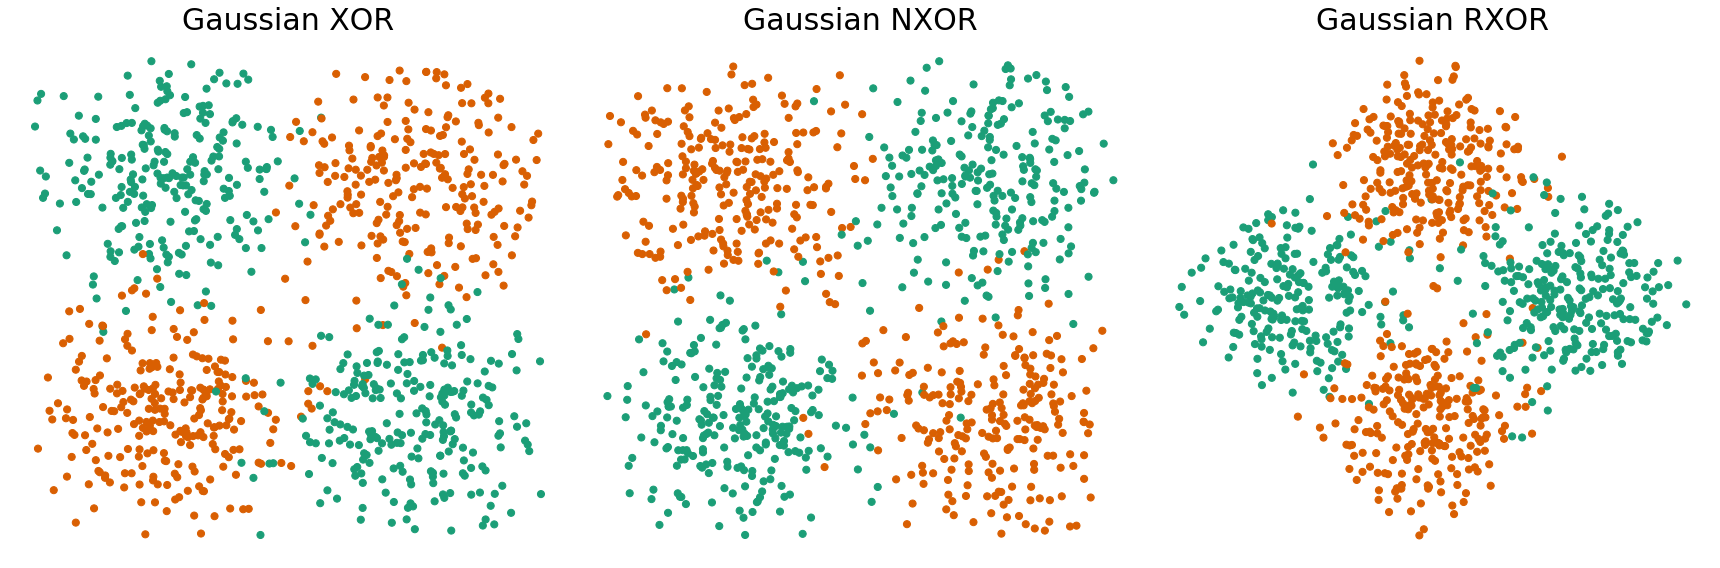

In [2]:
X_xor, y_xor = generate_gaussian_parity(1000)
X_nxor, y_nxor = generate_gaussian_parity(1000, angle_params=np.pi / 2)
X_rxor, y_rxor = generate_gaussian_parity(1000, angle_params=np.pi / 4)

colors = sns.color_palette("Dark2", n_colors=2)

fig, ax = plt.subplots(1, 3, figsize=(24, 8))

clr = [colors[i] for i in y_xor]
ax[0].scatter(X_xor[:, 0], X_xor[:, 1], c=clr, s=50)
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("Gaussian XOR", fontsize=30)
ax[0].axis("off")

clr = [colors[i] for i in y_nxor]
ax[1].scatter(X_nxor[:, 0], X_nxor[:, 1], c=clr, s=50)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title("Gaussian NXOR", fontsize=30)
ax[1].axis("off")

clr = [colors[i] for i in y_rxor]
ax[2].scatter(X_rxor[:, 0], X_rxor[:, 1], c=clr, s=50)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].set_title("Gaussian RXOR", fontsize=30)
ax[2].axis("off")

plt.tight_layout()

### Experiment definition

In [26]:
def experiment(
    n_task1,
    n_task2,
    n_test=1000,
    task1_angle=0,
    task2_angle=np.pi / 2,
    n_trees=50,
    random_state=None,
):

    """
    A function to do synergistic experiment between two tasks
    where the task data is generated using Gaussian parity.

    Parameters
    ----------
    n_task1 : int
        Total number of train sample for task 1.

    n_task2 : int
        Total number of train dsample for task 2

    n_test : int, optional (default=1000)
        Number of test sample for each task.

    task1_angle : float, optional (default=0)
        Angle in radian for task 1.

    task2_angle : float, optional (default=numpy.pi/2)
        Angle in radian for task 2.

    n_trees : int, optional (default=10)
        Number of total trees to train for each task.

    max_depth : int, optional (default=None)
        Maximum allowable depth for each tree.

    random_state : int, RandomState instance, default=None
        Determines random number generation for dataset creation. Pass an int
        for reproducible output across multiple function calls.


    Returns
    -------
    errors : array of shape [4]
        Elements of the array is organized as single task error task1,
        multitask error task1, single task error task2,
        multitask error task2.
    """

    if n_task1 == 0 and n_task2 == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    if random_state != None:
        np.random.seed(random_state)

    errors = np.zeros(6, dtype=float)

    source_model = kdf(k = 1e-2, kwargs={'n_estimators':n_trees})
    target_model = kdf(k = 1e-2, kwargs={'n_estimators':n_trees})

    # source data
    X_task1, y_task1 = generate_gaussian_parity(n_task1, angle_params=task1_angle)
    test_task1, test_label_task1 = generate_gaussian_parity(
        n_test, angle_params=task1_angle
    )

    # target data
    X_task2, y_task2 = generate_gaussian_parity(n_task2, angle_params=task2_angle)
    test_task2, test_label_task2 = generate_gaussian_parity(
        n_test, angle_params=task2_angle
    )

    if n_task1 == 0:
        target_model.fit(X_task2, y_task2)

        errors[0] = 0.5
        errors[1] = 0.5

        single_task2 = target_model.predict(
            test_task2
        )
        l2f_task2 = single_task2

        errors[2] = 1 - np.mean(single_task2 == test_label_task2)
        errors[3] = 1 - np.mean(l2f_task2 == test_label_task2)

    elif n_task2 == 0:
        source_model.fit(X_task1, y_task1)

        single_task1 = source_model.predict(
            test_task1
        )
        l2f_task1 = source_model.predict(test_task1)

        errors[0] = 1 - np.mean(single_task1 == test_label_task1)
        errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)

        errors[2] = 0.5
        errors[3] = 0.5
    else:
        source_model.fit(X_task1, y_task1)
        target_model.fit(X_task2, y_task2)

        single_task1 = source_model.predict(test_task1)
        single_task2 = target_model.predict(test_task2)
        
        ''''source_model_ = copy.deepcopy(source_model)
        source_model = update_kdf(X_task1, y_task1, target_model, source_model)
        target_model = update_kdf(X_task2, y_task2, source_model_, target_model)'''
        task1_proba1 = source_model.predict_proba(test_task1)
        task1_proba2 = target_model.predict_proba(test_task1)

        task1_proba = task1_proba1
        task1_proba[:,0] = (task1_proba1[:,0] + task1_proba2[:,1])/2
        task1_proba[:,1] = (task1_proba1[:,1] + task1_proba2[:,0])/2
        

        task2_proba1 = source_model.predict_proba(test_task2)
        task2_proba2 = target_model.predict_proba(test_task2)

        task2_proba = task2_proba1
        task2_proba[:,0] = (task2_proba1[:,1] + task2_proba2[:,0])/2
        task2_proba[:,1] = (task2_proba1[:,0] + task2_proba2[:,1])/2


        l2f_task1 = np.argmax(task1_proba, axis = 1)
        l2f_task2 = np.argmax(task2_proba, axis = 1)

        errors[0] = 1 - np.mean(single_task1 == test_label_task1)
        errors[1] = 1 - np.mean(l2f_task1 == test_label_task1)
        errors[2] = 1 - np.mean(single_task2 == test_label_task2)
        errors[3] = 1 - np.mean(l2f_task2 == test_label_task2)

    return errors

### Run experiment for XOR N-XOR tasks

In [33]:
mc_rep = 1000
n_test = 1000
n_trees = 100
n_xor = (100 * np.arange(0.5, 1.25, step=0.05)).astype(int)
n_nxor = (100 * np.arange(0.5, 1.50, step=0.05)).astype(int)

mean_error = np.zeros((6, len(n_xor) + len(n_nxor)))
std_error = np.zeros((6, len(n_xor) + len(n_nxor)))

mean_te = np.zeros((4, len(n_xor) + len(n_nxor)))
std_te = np.zeros((4, len(n_xor) + len(n_nxor)))

for i, n1 in enumerate(n_xor):
    print("starting to compute %s xor\n" % n1)
    error = np.array(
        Parallel(n_jobs=-1, verbose=0)(
            delayed(experiment)(n1, 0) for _ in range(mc_rep)
        )
    )
    mean_error[:, i] = np.mean(error, axis=0)
    std_error[:, i] = np.std(error, ddof=1, axis=0)
    mean_te[0, i] = np.mean(error[:, 0]) / np.mean(error[:, 1])
    mean_te[1, i] = np.mean(error[:, 2]) / np.mean(error[:, 3])
    mean_te[2, i] = np.mean(error[:, 0]) / np.mean(error[:, 4])
    mean_te[3, i] = np.mean(error[:, 2]) / np.mean(error[:, 5])

    if n1 == n_xor[-1]:
        for j, n2 in enumerate(n_nxor):
            print("starting to compute %s nxor\n" % n2)

            error = np.array(
                Parallel(n_jobs=-1, verbose=0)(
                    delayed(experiment)(n1, n2)
                    for _ in range(mc_rep)
                )
            )
            mean_error[:, i + j + 1] = np.mean(error, axis=0)
            std_error[:, i + j + 1] = np.std(error, ddof=1, axis=0)
            mean_te[0, i + j + 1] = np.mean(error[:, 0]) / np.mean(error[:, 1])
            mean_te[1, i + j + 1] = np.mean(error[:, 2]) / np.mean(error[:, 3])
            mean_te[2, i + j + 1] = np.mean(error[:, 0]) / np.mean(error[:, 4])
            mean_te[3, i + j + 1] = np.mean(error[:, 2]) / np.mean(error[:, 5])

with open("mean_xor_nxor.pickle", "wb") as f:
    pickle.dump(mean_error, f)

with open("std_xor_nxor.pickle", "wb") as f:
    pickle.dump(std_error, f)

with open("mean_te_xor_nxor.pickle", "wb") as f:
    pickle.dump(mean_te, f)

starting to compute 50 xor



ipykernel_launcher:24: RuntimeWarning: divide by zero encountered in double_scalars
ipykernel_launcher:25: RuntimeWarning: divide by zero encountered in double_scalars


starting to compute 55 xor

starting to compute 60 xor

starting to compute 65 xor

starting to compute 70 xor

starting to compute 75 xor

starting to compute 80 xor

starting to compute 85 xor

starting to compute 90 xor

starting to compute 95 xor

starting to compute 100 xor

starting to compute 105 xor

starting to compute 110 xor

starting to compute 115 xor

starting to compute 120 xor

starting to compute 50 nxor



ipykernel_launcher:41: RuntimeWarning: divide by zero encountered in double_scalars
ipykernel_launcher:42: RuntimeWarning: divide by zero encountered in double_scalars


starting to compute 55 nxor

starting to compute 60 nxor

starting to compute 65 nxor

starting to compute 70 nxor

starting to compute 75 nxor

starting to compute 80 nxor

starting to compute 85 nxor

starting to compute 90 nxor

starting to compute 95 nxor

starting to compute 100 nxor

starting to compute 105 nxor

starting to compute 110 nxor

starting to compute 115 nxor

starting to compute 120 nxor

starting to compute 125 nxor

starting to compute 130 nxor

starting to compute 135 nxor

starting to compute 140 nxor

starting to compute 145 nxor



### Plot XOR N-XOR results

ipykernel_launcher:138: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


(-1.1060825990889291,
 1.1078549175776984,
 -1.0996680840297355,
 1.0741305051767684)

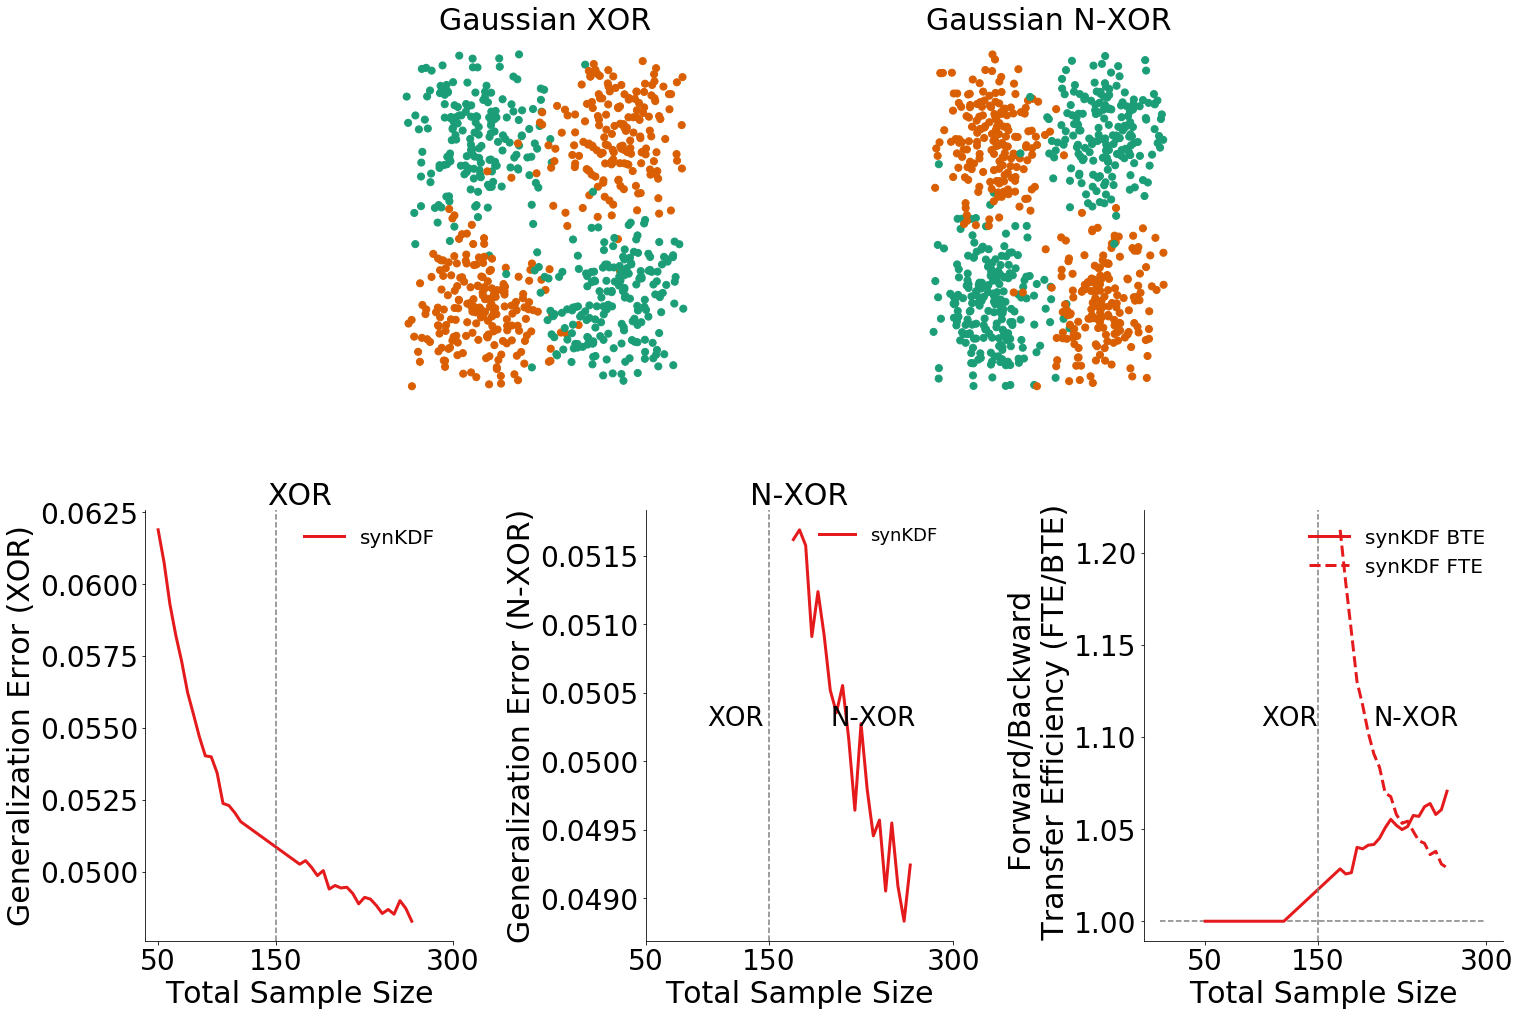

In [34]:
with open("mean_xor_nxor.pickle", "rb") as f:
    mean_error = pickle.load(f)

n_xor = (100 * np.arange(0.5, 1.25, step=0.05)).astype(int)
n_nxor = (100 * np.arange(0.5, 1.50, step=0.05)).astype(int)

n1s = n_xor
n2s = n_nxor

ns = np.concatenate((n1s, n2s + n1s[-1]))
ls = ["-", "--"]
algorithms = [
    "XOR KDF",
    "N-XOR KDF",
    "synKDF"
]


TASK1 = "XOR"
TASK2 = "N-XOR"

fontsize = 30
labelsize = 28

colors = sns.color_palette("Set1", n_colors=2)

fig = plt.figure(constrained_layout=True, figsize=(21, 14))
gs = fig.add_gridspec(14, 21)
ax1 = fig.add_subplot(gs[7:, :6])
ax1.plot(
    ns,
    mean_error[1],
    label=algorithms[2],
    c=colors[0],
    ls=ls[np.sum(1 > 1).astype(int)],
    lw=3,
)

ax1.set_ylabel("Generalization Error (%s)" % (TASK1), fontsize=fontsize)
ax1.legend(loc="upper right", fontsize=20, frameon=False)
# ax1.set_ylim(0.09, 0.21)
ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
# ax1.set_yticks([0.5,0.15, 0.25])
ax1.set_xticks([50, 150, 300])
ax1.axvline(x=150, c="gray", linewidth=1.5, linestyle="dashed")
ax1.set_title("XOR", fontsize=30)

right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

#ax1.text(400, np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
#ax1.text(900, np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

#####################################
with open("mean_xor_nxor.pickle", "rb") as f:
    mean_error = pickle.load(f)

TASK1 = "XOR"
TASK2 = "N-XOR"

ax1 = fig.add_subplot(gs[7:, 7:13])

ax1.plot(
    ns[len(n1s) :], mean_error[3, len(n1s) :], label=algorithms[2], c=colors[0], lw=3
)

ax1.set_ylabel("Generalization Error (%s)" % (TASK2), fontsize=fontsize)
ax1.legend(loc="upper right", fontsize=18, frameon=False)
ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
ax1.set_xticks([50, 150, 300])
ax1.axvline(x=150, c="gray", linewidth=1.5, linestyle="dashed")


right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)

ax1.text(100, np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
ax1.text(200, np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

ax1.set_title("N-XOR", fontsize=30)

#####################################
with open("mean_te_xor_nxor.pickle", "rb") as f:
    mean_te = pickle.load(f)

algorithms = ["synKDF BTE", "synKDF FTE"]

TASK1 = "XOR"
TASK2 = "N-XOR"

ax1 = fig.add_subplot(gs[7:, 14:])

ax1.plot(ns, mean_te[0], label=algorithms[0], c=colors[0], ls=ls[0], lw=3)
ax1.plot(
    ns[len(n1s) :],
    mean_te[1, len(n1s) :],
    label=algorithms[1],
    c=colors[0],
    ls=ls[1],
    lw=3,
)

ax1.set_ylabel("Forward/Backward \n Transfer Efficiency (FTE/BTE)", fontsize=fontsize)
ax1.legend(loc="upper right", fontsize=20, frameon=False)
ax1.set_xlabel("Total Sample Size", fontsize=fontsize)
ax1.tick_params(labelsize=labelsize)
# ax1.set_yticks([0,.5,1,1.5])
ax1.set_xticks([50, 150, 300])
ax1.axvline(x=150, c="gray", linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.hlines(1, 10, 300, colors="gray", linestyles="dashed", linewidth=1.5)

ax1.text(100, np.mean(ax1.get_ylim()), "%s" % (TASK1), fontsize=26)
ax1.text(200, np.mean(ax1.get_ylim()), "%s" % (TASK2), fontsize=26)

colors = sns.color_palette("Dark2", n_colors=2)

X, Y = generate_gaussian_parity(750, angle_params=0)
Z, W = generate_gaussian_parity(750, angle_params=np.pi / 2)

ax = fig.add_subplot(gs[:6, 4:10])
clr = [colors[i] for i in Y]
ax.scatter(X[:, 0], X[:, 1], c=clr, s=50)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Gaussian XOR", fontsize=30)

plt.tight_layout()
ax.axis("off")

colors = sns.color_palette("Dark2", n_colors=2)

ax = fig.add_subplot(gs[:6, 11:16])
clr = [colors[i] for i in W]
ax.scatter(Z[:, 0], Z[:, 1], c=clr, s=50)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Gaussian N-XOR", fontsize=30)
ax.axis("off")